In [1]:
import pandas as pd
import ast
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.style as mplstyle
from tqdm import tqdm
jet = plt.cm.jet
import datetime
# Invert the colormap
colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)
colors = [jet(x) for x in np.linspace(0.5, 1, 256)]
red_to_green = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)
data = pd.read_csv('week_43_lane_data.csv')

In [2]:
smooth_x_window = 1
smooth_t_window = 200
def beta_free(x,t,x_s,t_s,x_win=smooth_x_window,t_win=smooth_t_window,c_free=-80):
    dt = t-t_s- 3600*(x-x_s)/c_free
    dx = x-x_s
    return np.exp(-(np.abs(dx)/x_win + np.abs(dt)/t_win))

def beta_cong(x,t,x_s,t_s,x_win=smooth_x_window,t_win=smooth_t_window,c_cong=10):
    dt = t-t_s- 3600*(x-x_s)/c_cong
    dx = x-x_s
    return np.exp(-(np.abs(dx)/x_win + np.abs(dt)/t_win))

def EGTF(x,t,speed_raw_df):
    speed = speed_raw_df[(np.abs(speed_raw_df.t - t)<=(smooth_t_window/2)) & (np.abs(speed_raw_df.x - x)<=(smooth_x_window/2))].copy()
    
    speed = speed.dropna()
#     print(len(speed))
    EGTF_v_free = 80
    EGTF_v_cong = 80
    # Now apply your functions
    speed['beta_free'] = speed.apply(lambda v: beta_free(x, t, v.x, v.t), axis=1)
    speed['beta_cong'] = speed.apply(lambda v: beta_cong(x, t, v.x, v.t), axis=1)
    if((sum(speed.beta_free)!=0) & (sum(speed.beta_cong)!=0)):
        EGTF_v_free = sum(speed.beta_free * speed.speed) / sum(speed.beta_free)
        EGTF_v_cong = sum(speed.beta_cong * speed.speed) / sum(speed.beta_cong)
#         print(EGTF_v_free,EGTF_v_cong)
    v = min(EGTF_v_free,EGTF_v_cong)
    tanh_term = np.tanh( (36-v) / 3.1)
    w = 0.5*(1+tanh_term)
#     return speed, w*EGTF_v_cong + (1-w)*EGTF_v_free
    return w*EGTF_v_cong + (1-w)*EGTF_v_free

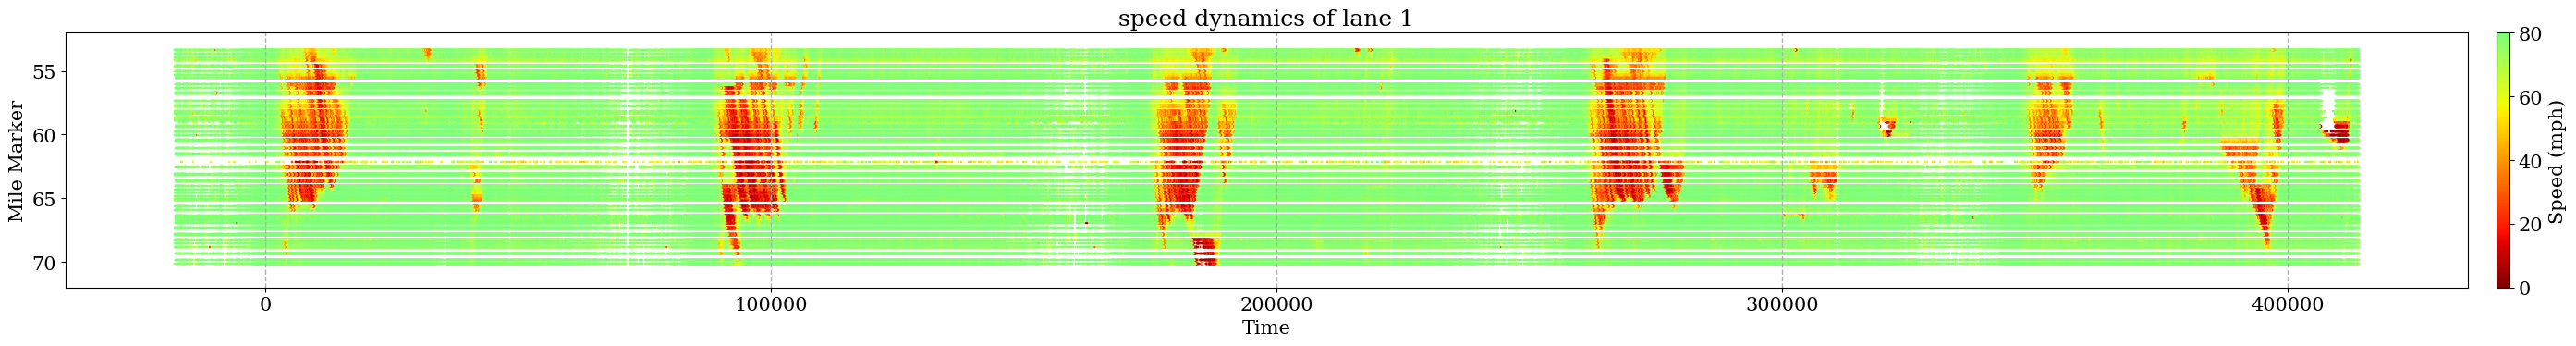

In [3]:
lane = 1
plt.figure(figsize=(32,4), facecolor='white')
plt.rc('font', family='serif', size=15)
plt.rc('xtick', color='black', labelsize=15)  # Adjust labelsize as needed
plt.rc('ytick', color='black', labelsize=15)  # Adjust labelsize as needed
plt.rc('axes', labelcolor='black', edgecolor='black', titlecolor='black')
ax = plt.gca()
ax.set_facecolor('white')
ax.xaxis.grid(True,linestyle='--',linewidth=1)
sc = plt.scatter(data.time_unix.values - data.time_unix.min() - 3600 * 5 - 3600*24*0, data.milemarker.values, 
                c=data[f'lane{lane}_speed'].values,vmin=0,vmax=80,marker='s',
                cmap=green_to_red,s=1)
# for on_ramp in on_ramps:
#     plt.plot([11000, 11500], [on_ramp, on_ramp], color='white', linestyle='--')
# for off_ramp in off_ramps:
#     plt.plot([11000, 11500], [off_ramp, off_ramp], color='white', linestyle='-')
# plt.xlim(70000,75000)
# xlabels = ['5:00', '5:30', '6:00', '6:30','7:00','7:30','8:00']
# plt.xticks([0,1800,3600,5400,7200,9000,10800],labels=xlabels)
plt.xlabel('Time')
plt.ylim(52,72)
start_time = datetime.datetime.strptime("5:00", "%H:%M")
ticks = list(range(0, 3600*6+1, 1800))
xlabels = [(start_time + datetime.timedelta(seconds=tick)).strftime("%H:%M") for tick in ticks]
# plt.xticks(ticks, labels=xlabels, rotation=0)
# plt.xlim(0,3600*6)
# xlabels = ['5:30','6:00', '6:30', '7:00', '7:30','8:00']
# plt.xticks([0,1800,3600,5400,7200,9000],labels=xlabels)
plt.ylabel('Mile Marker')
plt.title(f'speed dynamics of lane {lane}')
plt.gca().invert_yaxis()
plt.colorbar(sc,pad=0.01).set_label('Speed (mph)', rotation=90, labelpad=5)  # Adjust label according to your preference
plt.tight_layout()
plt.show()

In [91]:
data.head()

time_unix  milemarker  speed  volume  occupancy  lane1_speed  \
0  1.698487e+09        53.6   71.0    12.0        3.0         80.0   
1  1.698487e+09        60.0   78.0     5.0        1.0          NaN   
2  1.698487e+09        64.5   75.0     8.0        1.0         81.0   
3  1.698487e+09        57.7   67.0     9.0        3.0          NaN   
4  1.698487e+09        59.7   78.0     8.0        3.0          NaN   

   lane1_volume  lane1_occ  lane2_speed  lane2_volume  lane2_occ  lane3_speed  \
0           1.0        1.0         69.0           5.0        7.0         74.0   
1           0.0        0.0         86.0           1.0        1.0         72.0   
2           1.0        1.0         78.0           4.0        2.0         64.0   
3           0.0        0.0         75.0           3.0        2.0         65.0   
4           0.0        0.0         81.0           2.0        1.0         77.0   

   lane3_volume  lane3_occ  lane4_speed  lane4_volume  lane4_occ  
0           4.0        3.0         70.0           2.0        3.0  
1           2.0        1.0         82.0           2.0        1.0  
2           1.0        1.0         75.0           2.0        1.0  
3           2.0        4.0         62.0           4.0        5.0  
4           6.0        5.0          NaN           0.0        0.0

100%|██████████████████████████████████| 141071/141071 [03:09<00:00, 742.62it/s]


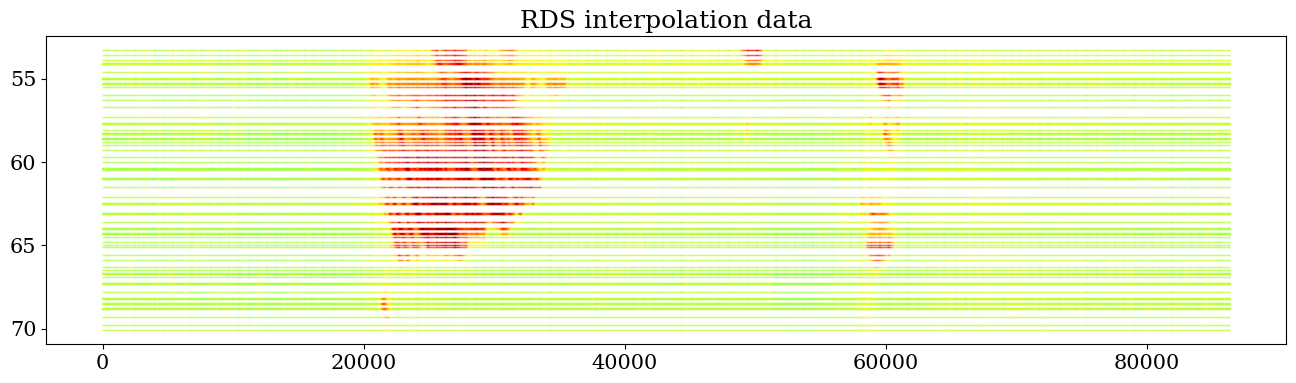

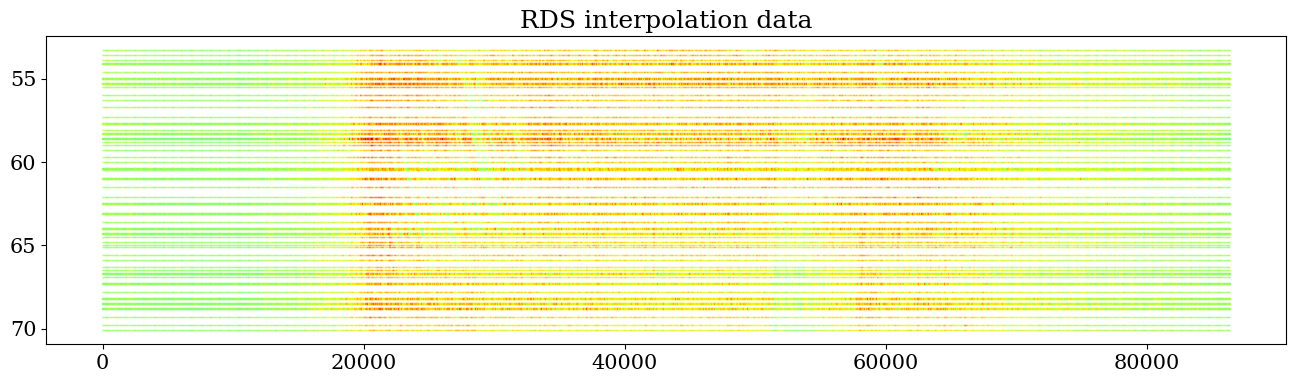

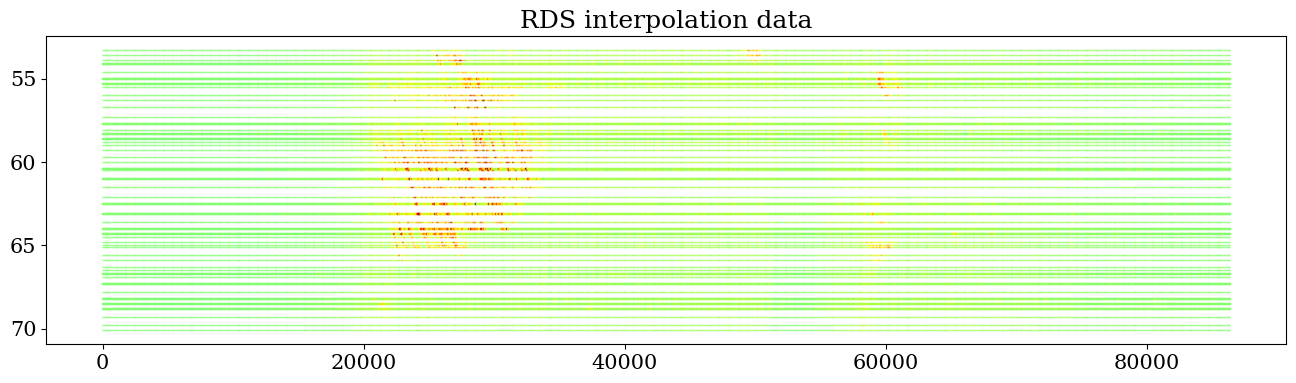

100%|██████████████████████████████████| 141071/141071 [03:13<00:00, 727.43it/s]


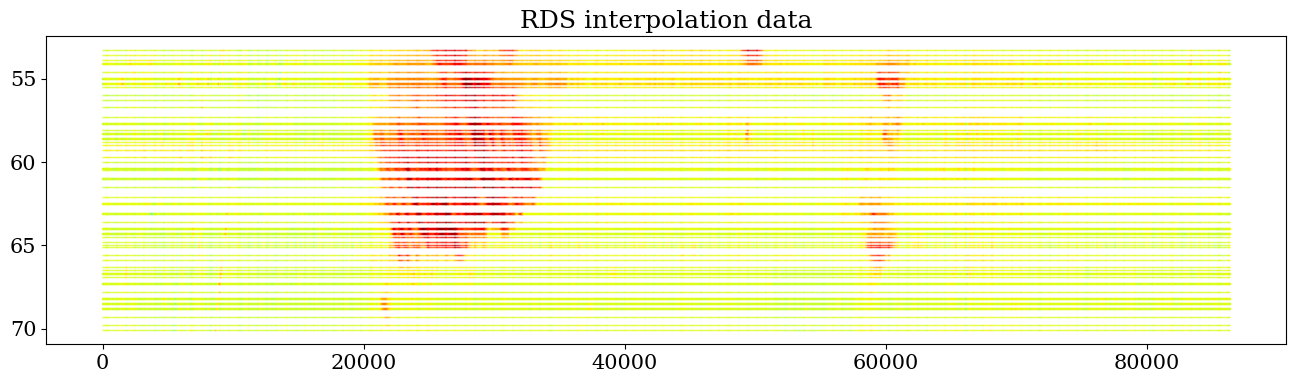

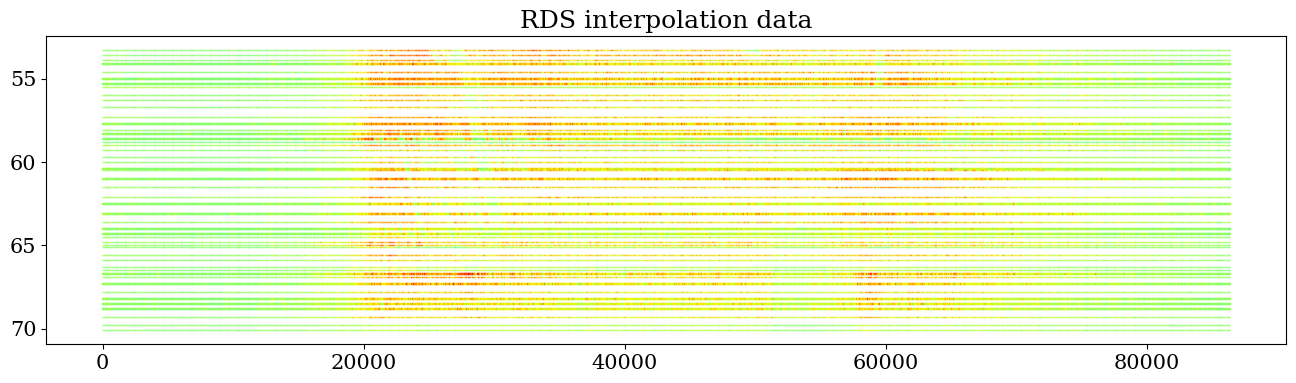

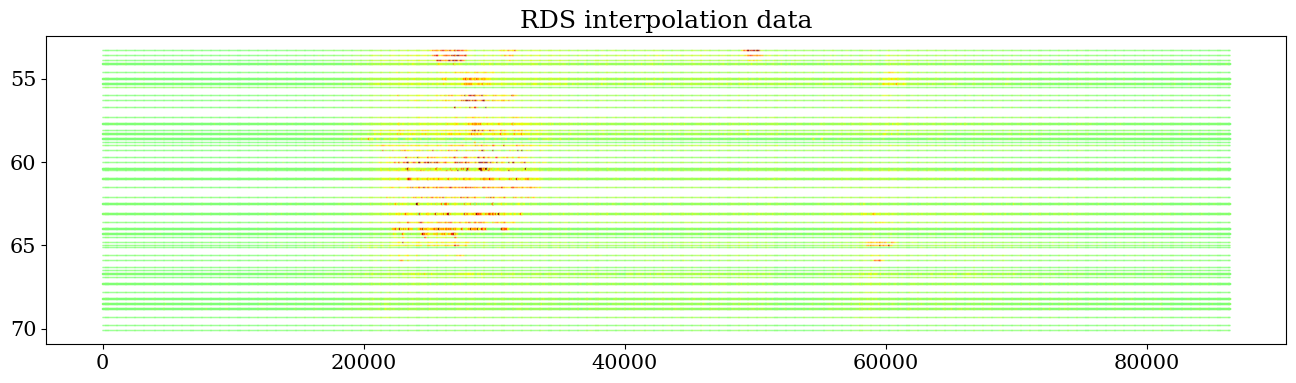

In [97]:
# process_lane = 1
# process_day = 1
# process_var = 'occ'
for process_lane in range(3,5):
    for process_var in ['speed','volume','occ']:
        # process_var = 'volume'
        lane_data = data[['time_unix','milemarker',f'lane{process_lane}_{process_var}']]
        lane_data.columns = ['time_unix','milemarker',process_var]
        first_unix_time = lane_data.time_unix.min()
        lane_data['time'] = lane_data['time_unix'] - first_unix_time 
        lane_data['time_index'] = lane_data['time']//30
        lane_day = lane_data[(lane_data.time>0 + 3600*24*(process_day-1)) & (lane_data.time<=3600*24*(process_day))]
        lane_day = lane_day.dropna().reset_index(drop=True)
        # Time range from 0 to 43200 every 30 seconds
        time = np.arange(round(lane_day.time_index.min(),0), round(lane_day.time_index.max(),0), 1)
        # Space values provided in the list array
        space = data.milemarker.unique()
        # space = np.arange(53.3, 70.2, 0.1)
        time_grid, space_grid = np.meshgrid(time, space)
        time_flat = time_grid.flatten()
        space_flat = space_grid.flatten()
        ld_full = pd.DataFrame({'time_index': time_flat, 'milemarker': space_flat})
        ld_full['milemarker'] = ld_full['milemarker'].apply(lambda v: round(v,2))
        ld_full['var'] = ld_full.apply(lambda v: 
                                             lane_day[(lane_day.time_index == v.time_index) & (lane_day.milemarker == v.milemarker)][f'{process_var}'].mean(),axis=1)
        ld_full['time'] = ld_full['time_index']*30
        if(process_var == 'speed'):
            ld_full.columns = ['time_index','x','speed','t']
            raw_data = ld_full.copy()
            # raw_data = raw_data.sort_values(by=['t', 'x'])
            raw_data = raw_data.sort_values(by=[ 'x','t']).reset_index(drop=True)
            raw_data['raw_speed'] = raw_data[f'{process_var}']
            tqdm.pandas()
            # raw_data['speed'] = raw_data.progress_apply(lambda v: v.speed if v.speed < 90 else EGTF(v.x, v.t, raw_data), axis=1)
            raw_data['speed'] = raw_data.progress_apply(lambda v: EGTF(v.x, v.t, raw_data), axis=1)
            raw_data.columns = ['time_index','milemarker',process_var,'time',f'raw_{process_var}']
            raw_data['unix_time'] = raw_data['time'] + first_unix_time
            raw_data.to_csv(f'processed_data/day_{process_day}_lane{process_lane}_{process_var}.csv')
            plt.figure(figsize=(16,4), facecolor='white')
            plt.rc('font', family='serif', size=15)
            sc = plt.scatter(raw_data.time.values , raw_data.milemarker.values, 
                            c=raw_data[f'{process_var}'].values,marker='s',
                            cmap=green_to_red,s=0.1)
            plt.gca().invert_yaxis()
            plt.title('RDS interpolation data')
            plt.show()
        if(process_var != 'speed'):
            ld_full.columns = ['time_index','x','var','t']
            raw_data = ld_full.copy()
            raw_data[f'raw_{process_var}'] = raw_data['var']
            raw_data = raw_data.sort_values(by=[ 'x','t']).reset_index(drop=True)
            raw_data['var'] = raw_data['var'].interpolate(method='linear')
            raw_data.columns = ['time_index','milemarker',process_var,'time',f'raw_{process_var}']
            raw_data['unix_time'] = raw_data['time'] + first_unix_time
            raw_data.to_csv(f'processed_data/day_{process_day}_lane{process_lane}_{process_var}.csv')
            plt.figure(figsize=(16,4), facecolor='white')
            plt.rc('font', family='serif', size=15)
            sc = plt.scatter(raw_data.time.values , raw_data.milemarker.values, 
                            c=raw_data[f'{process_var}'].values,marker='s',
                            cmap=red_to_green,s=0.1)
            plt.gca().invert_yaxis()
            plt.title('RDS interpolation data')
            plt.show()

In [100]:
raw_data.columns

Index(['time_index', 'milemarker', 'occ', 'time', 'raw_occ', 'unix_time'], dtype='object')

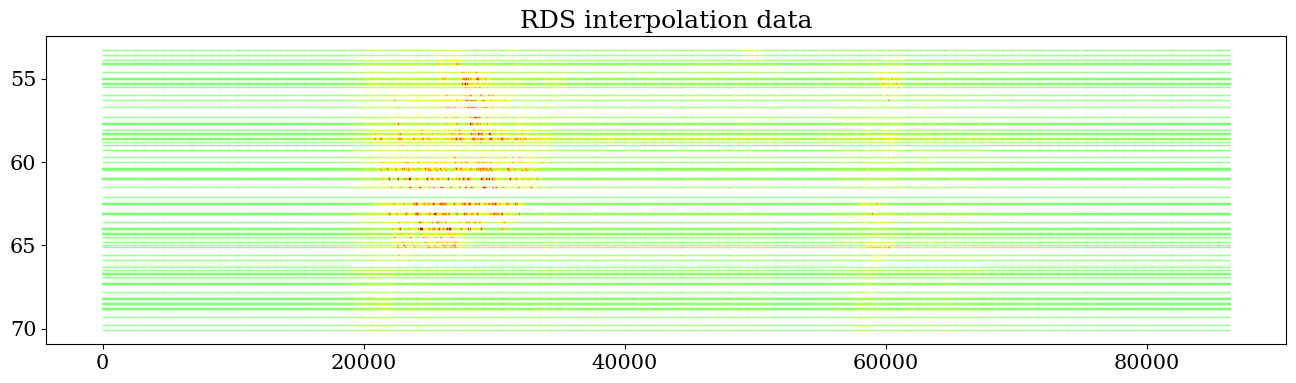

In [94]:
process_lane = 1
process_day = 1
process_var = 'occ'
# process_var = 'volume'
lane_data = data[['time_unix','milemarker',f'lane{process_lane}_{process_var}']]
lane_data.columns = ['time_unix','milemarker',process_var]
first_unix_time = lane_data.time_unix.min()
lane_data['time'] = lane_data['time_unix'] - first_unix_time 
lane_data['time_index'] = lane_data['time']//30
lane_day = lane_data[(lane_data.time>0 + 3600*24*(process_day-1)) & (lane_data.time<=3600*24*(process_day))]
lane_day = lane_day.dropna().reset_index(drop=True)
# Time range from 0 to 43200 every 30 seconds
time = np.arange(round(lane_day.time_index.min(),0), round(lane_day.time_index.max(),0), 1)
# Space values provided in the list array
space = data.milemarker.unique()
# space = np.arange(53.3, 70.2, 0.1)
time_grid, space_grid = np.meshgrid(time, space)
time_flat = time_grid.flatten()
space_flat = space_grid.flatten()
ld_full = pd.DataFrame({'time_index': time_flat, 'milemarker': space_flat})
ld_full['milemarker'] = ld_full['milemarker'].apply(lambda v: round(v,2))
ld_full['var'] = ld_full.apply(lambda v: 
                                     lane_day[(lane_day.time_index == v.time_index) & (lane_day.milemarker == v.milemarker)][f'{process_var}'].mean(),axis=1)
ld_full['time'] = ld_full['time_index']*30
if(process_var == 'speed'):
    ld_full.columns = ['time_index','x','speed','t']
    raw_data = ld_full.copy()
    # raw_data = raw_data.sort_values(by=['t', 'x'])
    raw_data = raw_data.sort_values(by=[ 'x','t']).reset_index(drop=True)
    raw_data['raw_speed'] = raw_data[f'{process_var}']
    tqdm.pandas()
    # raw_data['speed'] = raw_data.progress_apply(lambda v: v.speed if v.speed < 90 else EGTF(v.x, v.t, raw_data), axis=1)
    raw_data['speed'] = raw_data.progress_apply(lambda v: EGTF(v.x, v.t, raw_data), axis=1)
    raw_data.columns = ['time_index','milemarker',process_var,'time',f'raw_{process_var}']
    raw_data['unix_time'] = raw_data['time'] + first_unix_time
    raw_data.to_csv(f'processed_data/day_{process_day}_lane{process_lane}_{process_var}.csv')
    plt.figure(figsize=(16,4), facecolor='white')
    plt.rc('font', family='serif', size=15)
    sc = plt.scatter(raw_data.time.values , raw_data.milemarker.values, 
                    c=raw_data[f'{process_var}'].values,vmin =0, vmax=80, marker='s',
                    cmap=green_to_red,s=0.1)
    plt.gca().invert_yaxis()
    plt.title('RDS interpolation data')
    plt.show()
if(process_var != 'speed'):
    ld_full.columns = ['time_index','x','var','t']
    raw_data = ld_full.copy()
    raw_data[f'raw_{process_var}'] = raw_data['var']
    raw_data = raw_data.sort_values(by=[ 'x','t']).reset_index(drop=True)
    raw_data['var'] = raw_data['var'].interpolate(method='linear')
    raw_data.columns = ['time_index','milemarker',process_var,'time',f'raw_{process_var}']
    raw_data['unix_time'] = raw_data['time'] + first_unix_time
    raw_data.to_csv(f'processed_data/day_{process_day}_lane{process_lane}_{process_var}.csv')
    plt.figure(figsize=(16,4), facecolor='white')
    plt.rc('font', family='serif', size=15)
    sc = plt.scatter(raw_data.time.values , raw_data.milemarker.values, 
                    c=raw_data[f'{process_var}'].values,marker='s',
                    cmap=red_to_green,s=0.1)
    plt.gca().invert_yaxis()
    plt.title('RDS interpolation data')
    plt.show()

Text(0.5, 1.0, 'RDS interpolation data')

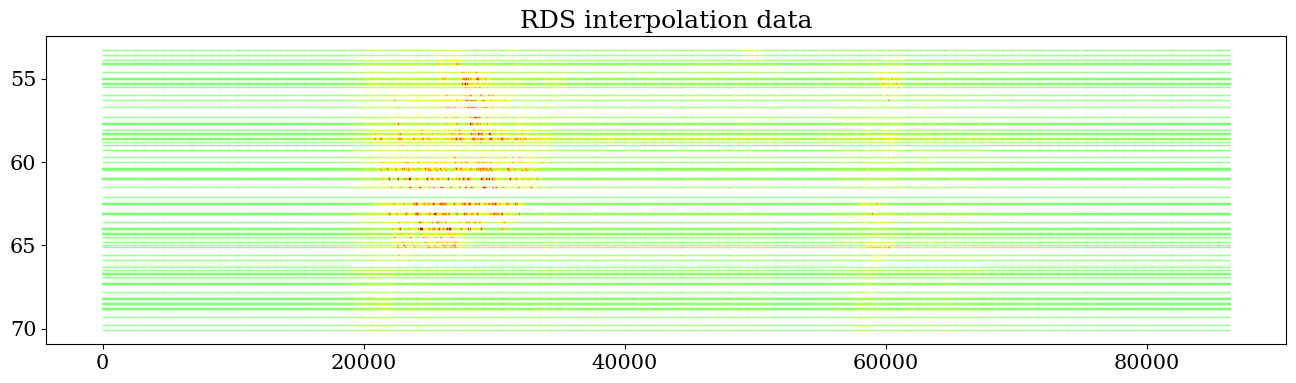

In [93]:
    plt.figure(figsize=(16,4), facecolor='white')
    plt.rc('font', family='serif', size=15)
    sc = plt.scatter(raw_data.time.values , raw_data.milemarker.values, 
                    c=raw_data[f'{process_var}'].values,marker='s',
                    cmap=red_to_green,s=0.1)
    plt.gca().invert_yaxis()
    plt.title('RDS interpolation data')

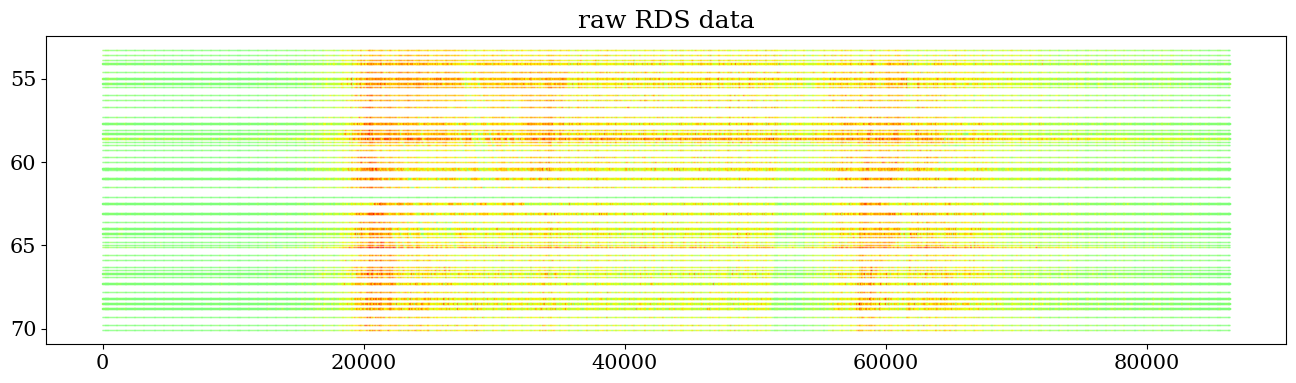

In [57]:
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# sc = plt.scatter(raw_data.t.values , raw_data.x.values, 
#                 c=raw_data['var'].values,marker='s',
#                 cmap=red_to_green,s=0.1)
# plt.gca().invert_yaxis()
# plt.title('RDS interpolation data data')
# plt.show()

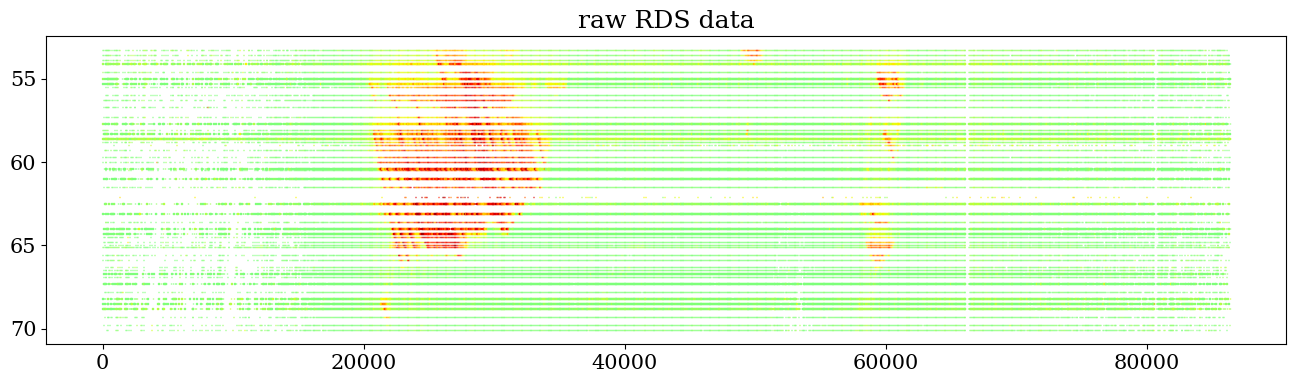

In [26]:
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# sc = plt.scatter(raw_data.t.values , raw_data.x.values, 
#                 c=raw_data.raw_speed.values,vmin=0,vmax=80,marker='s',
#                 cmap=green_to_red,s=0.1)
# plt.gca().invert_yaxis()
# plt.title('raw RDS data')
# plt.show()

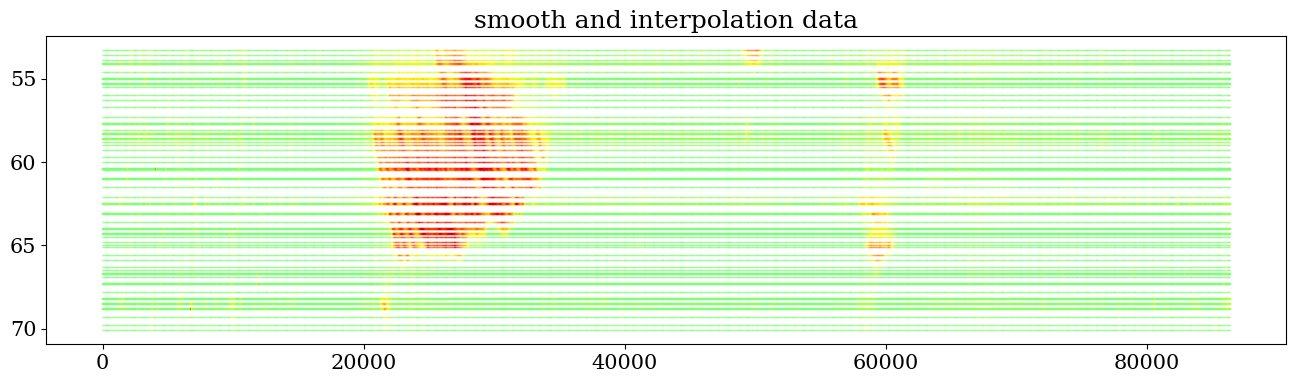

In [27]:
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# sc = plt.scatter(raw_data.t.values , raw_data.x.values, 
#                 c=raw_data.speed.values,vmin=0,vmax=80,marker='s',
#                 cmap=green_to_red,s=0.1)
# plt.gca().invert_yaxis()
# # plt.ylim(65,60)
# # plt.xlim(21000,22500)
# plt.title('smooth and interpolation data')
# plt.show()

In [77]:
# case  = raw_data.iloc[1000]
# speed, t = EGTF(case.x, case.t,sub_data)
# plt.figure(figsize=(4,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# sc = plt.scatter(speed.t.values , speed.x.values, 
#                 c=speed.beta_cong.values,vmin=0,vmax=1,marker='s',
#                 cmap=green_to_red,s=5)

In [86]:
# lane1 = data[['time_unix','milemarker','lane1_volume']]
# lane1.columns = ['time_unix','milemarker','volume']
# lane1['time'] = lane1['time_unix'] - lane1.time_unix.min()
# lane1['time_index'] = lane1['time']//30

In [87]:
# d1l1 = lane1[(lane1.time>3600*5) & (lane1.time<=3600*10)]
# d1l1 = d1l1.reset_index(drop=True)

In [88]:
# # Time range from 0 to 43200 every 30 seconds
# time = np.arange(600, 600+3600*5/30, 1)
# # Space values provided in the list array
# space = data.milemarker.unique()
# # space = np.arange(53.3, 70.2, 0.1)
# time_grid, space_grid = np.meshgrid(time, space)
# time_flat = time_grid.flatten()
# space_flat = space_grid.flatten()
# d1l1_full = pd.DataFrame({'time_index': time_flat, 'milemarker': space_flat})
# d1l1_full['milemarker'] = d1l1_full['milemarker'].apply(lambda v: round(v,2))

In [116]:
# d1l1_full['volume'] = d1l1_full.apply(lambda v: 
#                                      d1l1[(d1l1.time_index == v.time_index) & (d1l1.milemarker == v.milemarker)].volume.mean(),axis=1)

In [117]:
# d1l1_full['time'] = d1l1_full['time_index']*30
# d1l1_full = d1l1_full.sort_values(by=[ 'time','milemarker']).reset_index(drop=True)
# d1l1_full 

time_index  milemarker  volume     time
0           600.0        53.3     1.0  18000.0
1           600.0        53.6     5.0  18000.0
2           600.0        53.9     9.0  18000.0
3           600.0        54.1     2.0  18000.0
4           600.0        54.6     4.0  18000.0
...           ...         ...     ...      ...
29395      1199.0        68.5     7.0  35970.0
29396      1199.0        68.8     2.0  35970.0
29397      1199.0        69.3     2.0  35970.0
29398      1199.0        69.8     5.0  35970.0
29399      1199.0        70.1    10.0  35970.0

[29400 rows x 4 columns]

In [118]:
# d1l1_full = d1l1_full.interpolate(method='linear')


time_index  milemarker  volume     time
0           600.0        53.3     1.0  18000.0
1           600.0        53.6     5.0  18000.0
2           600.0        53.9     9.0  18000.0
3           600.0        54.1     2.0  18000.0
4           600.0        54.6     4.0  18000.0
...           ...         ...     ...      ...
29395      1199.0        68.5     7.0  35970.0
29396      1199.0        68.8     2.0  35970.0
29397      1199.0        69.3     2.0  35970.0
29398      1199.0        69.8     5.0  35970.0
29399      1199.0        70.1    10.0  35970.0

[29400 rows x 4 columns]

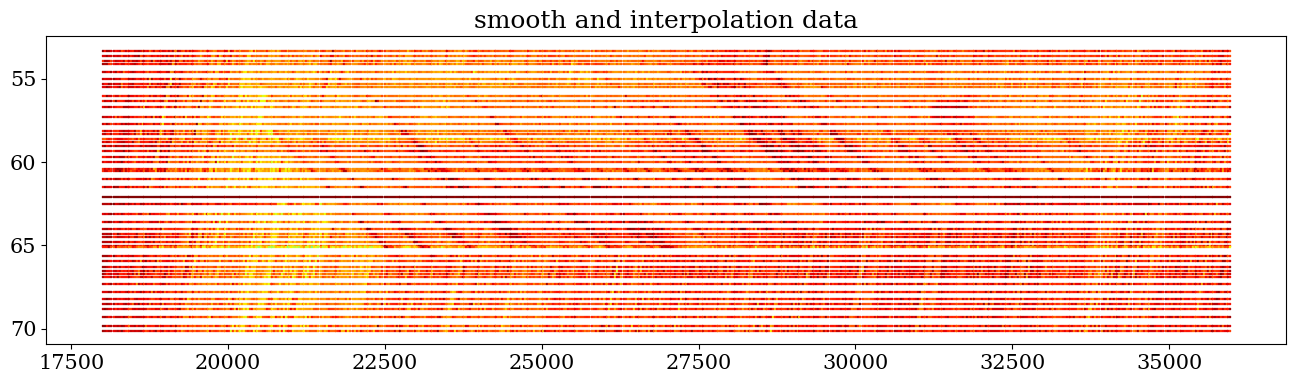

In [119]:
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# sc = plt.scatter(d1l1_full.time.values , d1l1_full.milemarker.values, 
#                 c=d1l1_full.volume.values,marker='s',
#                 cmap=green_to_red,s=0.5)
# plt.gca().invert_yaxis()
# # plt.ylim(65,60)
# # plt.xlim(21000,22500)
# plt.title('smooth and interpolation data')
# plt.show()